<h1>
    Predicting House Prices
    </h1>
    

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from fastai.imports import *
from fastai.tabular import * 
from fastai.callbacks import *
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox
import seaborn as sns

In [3]:
PATH = 'C:/Users/Alan/.fastai/data/houses/'
PATH

'C:/Users/Alan/.fastai/data/houses/'

In [4]:
df_raw = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

In [5]:
len(df_test)

1459

In [6]:
# for the purpose of evaluation of current competition we transform target value
df_raw.SalePrice = np.log1p(df_raw.SalePrice)

In [7]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
display_all(df_raw.head().T)

0        1        2        3        4
Id                   1        2        3        4        5
MSSubClass          60       20       60       70       60
MSZoning            RL       RL       RL       RL       RL
LotFrontage         65       80       68       60       84
LotArea           8450     9600    11250     9550    14260
Street            Pave     Pave     Pave     Pave     Pave
Alley              NaN      NaN      NaN      NaN      NaN
LotShape           Reg      Reg      IR1      IR1      IR1
LandContour        Lvl      Lvl      Lvl      Lvl      Lvl
Utilities       AllPub   AllPub   AllPub   AllPub   AllPub
LotConfig       Inside      FR2   Inside   Corner      FR2
LandSlope          Gtl      Gtl      Gtl      Gtl      Gtl
Neighborhood   CollgCr  Veenker  CollgCr  Crawfor  NoRidge
Condition1        Norm    Feedr     Norm     Norm     Norm
Condition2        Norm     Norm     Norm     Norm     Norm
BldgType          1Fam     1Fam     1Fam     1Fam     1Fam
HouseStyle      2Story   1Story   2Story   2Story   2Story
OverallQual          7        6        7        7        8
OverallCond          5        8        5        5        5
YearBuilt         2003     1976     2001     1915     2000
YearRemodAdd      2003     1976     2002     1970     2000
RoofStyle        Gable    Gable    Gable    Gable    Gable
RoofMatl       CompShg  CompShg  CompShg  CompShg  CompShg
Exterior1st    VinylSd  MetalSd  VinylSd  Wd Sdng  VinylSd
Exterior2nd    VinylSd  MetalSd  VinylSd  Wd Shng  VinylSd
MasVnrType     BrkFace     None  BrkFace     None  BrkFace
MasVnrArea         196        0      162        0      350
ExterQual           Gd       TA       Gd       TA       Gd
ExterCond           TA       TA       TA       TA       TA
Foundation       PConc   CBlock    PConc   BrkTil    PConc
BsmtQual            Gd       Gd       Gd       TA       Gd
BsmtCond            TA       TA       TA       Gd       TA
BsmtExposure        No       Gd       Mn       No       Av
BsmtFinType1       GLQ      ALQ      GLQ      ALQ      GLQ
BsmtFinSF1         706      978      486      216      655
BsmtFinType2       Unf      Unf      Unf      Unf      Unf
BsmtFinSF2           0        0        0        0        0
BsmtUnfSF          150      284      434      540      490
TotalBsmtSF        856     1262      920      756     1145
Heating           GasA     GasA     GasA     GasA     GasA
HeatingQC           Ex       Ex       Ex       Gd       Ex
CentralAir           Y        Y        Y        Y        Y
Electrical       SBrkr    SBrkr    SBrkr    SBrkr    SBrkr
1stFlrSF           856     1262      920      961     1145
2ndFlrSF           854        0      866      756     1053
LowQualFinSF         0        0        0        0        0
GrLivArea         1710     1262     1786     1717     2198
BsmtFullBath         1        0        1        1        1
BsmtHalfBath         0        1        0        0        0
FullBath             2        2        2        1        2
HalfBath             1        0        1        0        1
BedroomAbvGr         3        3        3        3        4
KitchenAbvGr         1        1        1        1        1
KitchenQual         Gd       TA       Gd       Gd       Gd
TotRmsAbvGrd         8        6        6        7        9
Functional         Typ      Typ      Typ      Typ      Typ
Fireplaces           0        1        1        1        1
FireplaceQu        NaN       TA       TA       Gd       TA
GarageType      Attchd   Attchd   Attchd   Detchd   Attchd
GarageYrBlt       2003     1976     2001     1998     2000
GarageFinish       RFn      RFn      RFn      Unf      RFn
GarageCars           2        2        2        3        3
GarageArea         548      460      608      642      836
GarageQual          TA       TA       TA       TA       TA
GarageCond          TA       TA       TA       TA       TA
PavedDrive           Y        Y        Y        Y        Y
WoodDeckSF           0      298        0        0      192
OpenPorch

In [9]:
df_raw.describe().transpose()

count          mean          std          min          25%  \
Id             1460.0    730.500000   421.610009     1.000000   365.750000   
MSSubClass     1460.0     56.897260    42.300571    20.000000    20.000000   
LotFrontage    1201.0     70.049958    24.284752    21.000000    59.000000   
LotArea        1460.0  10516.828082  9981.264932  1300.000000  7553.500000   
OverallQual    1460.0      6.099315     1.382997     1.000000     5.000000   
OverallCond    1460.0      5.575342     1.112799     1.000000     5.000000   
YearBuilt      1460.0   1971.267808    30.202904  1872.000000  1954.000000   
YearRemodAdd   1460.0   1984.865753    20.645407  1950.000000  1967.000000   
MasVnrArea     1452.0    103.685262   181.066207     0.000000     0.000000   
BsmtFinSF1     1460.0    443.639726   456.098091     0.000000     0.000000   
BsmtFinSF2     1460.0     46.549315   161.319273     0.000000     0.000000   
BsmtUnfSF      1460.0    567.240411   441.866955     0.000000   223.000000   
TotalBsmtSF    1460.0   1057.429452   438.705324     0.000000   795.750000   
1stFlrSF       1460.0   1162.626712   386.587738   334.000000   882.000000   
2ndFlrSF       1460.0    346.992466   436.528436     0.000000     0.000000   
LowQualFinSF   1460.0      5.844521    48.623081     0.000000     0.000000   
GrLivArea      1460.0   1515.463699   525.480383   334.000000  1129.500000   
BsmtFullBath   1460.0      0.425342     0.518911     0.000000     0.000000   
BsmtHalfBath   1460.0      0.057534     0.238753     0.000000     0.000000   
FullBath       1460.0      1.565068     0.550916     0.000000     1.000000   
HalfBath       1460.0      0.382877     0.502885     0.000000     0.000000   
BedroomAbvGr   1460.0      2.866438     0.815778     0.000000     2.000000   
KitchenAbvGr   1460.0      1.046575     0.220338     0.000000     1.000000   
TotRmsAbvGrd   1460.0      6.517808     1.625393     2.000000     5.000000   
Fireplaces     1460.0      0.613014     0.644666     0.000000     0.000000   
GarageYrBlt    1379.0   1978.506164    24.689725  1900.000000  1961.000000   
GarageCars     1460.0      1.767123     0.747315     0.000000     1.000000   
GarageArea     1460.0    472.980137   213.804841     0.000000   334.500000   
WoodDeckSF     1460.0     94.244521   125.338794     0.000000     0.000000   
OpenPorchSF    1460.0     46.660274    66.256028     0.000000     0.000000   
EnclosedPorch  1460.0     21.954110    61.119149     0.000000     0.000000   
3SsnPorch      1460.0      3.409589    29.317331     0.000000     0.000000   
ScreenPorch    1460.0     15.060959    55.757415     0.000000     0.000000   
PoolArea       1460.0      2.758904    40.177307     0.000000     0.000000   
MiscVal        1460.0     43.489041   496.123024     0.000000     0.000000   
MoSold         1460.0      6.321918     2.703626     1.000000     5.000000   
YrSold         1460.0   2007.815753     1.328095  2006.000000  2007.000000   
SalePrice      1460.0     12.024057     0.399449    10.460271    11.775105   

                       50%           75%            max  
Id              730.500000   1095.250000    1460.000000  
MSSubClass       50.000000     70.000000     190.000000  
LotFrontage      69.000000     80.000000     313.000000  
LotArea        9478.500000  11601.500000  215245.000000  
OverallQual       6.000000      7.000000      10.000000  
OverallCond       5.000000      6.000000       9.000000  
YearBuilt      1973.000000   2000.000000    2010.000000  
YearRemodAdd   1994.000000   2004.000000    2010.000000  
MasVnrArea        0.000000    166.000000    1600.000000  
BsmtFinSF1      383.500000    712.250000    5644.000000  
BsmtFinSF2        0.000000      0.000000    1474.000000  
BsmtUnfSF       477.500000    808.000000    2336.000000  
TotalBsmtSF     991.500000   1298.250000    6110.000000  
1stFlrSF       1087.000000   1391.250000    4692.000000  
2ndFlrSF          0.000000    728.000000    2065.000000  
LowQualFinSF      0.000000      0.000000     

In [10]:
dfna = df_raw.isna().any() 
cols = df_raw.columns[dfna]

In [11]:
df_raw[cols].head(20)

LotFrontage Alley MasVnrType  MasVnrArea BsmtQual BsmtCond BsmtExposure  \
0          65.0   NaN    BrkFace       196.0       Gd       TA           No   
1          80.0   NaN       None         0.0       Gd       TA           Gd   
2          68.0   NaN    BrkFace       162.0       Gd       TA           Mn   
3          60.0   NaN       None         0.0       TA       Gd           No   
4          84.0   NaN    BrkFace       350.0       Gd       TA           Av   
5          85.0   NaN       None         0.0       Gd       TA           No   
6          75.0   NaN      Stone       186.0       Ex       TA           Av   
7           NaN   NaN      Stone       240.0       Gd       TA           Mn   
8          51.0   NaN       None         0.0       TA       TA           No   
9          50.0   NaN       None         0.0       TA       TA           No   
10         70.0   NaN       None         0.0       TA       TA           No   
11         85.0   NaN      Stone       286.0       Ex       TA           No   
12          NaN   NaN       None         0.0       TA       TA           No   
13         91.0   NaN      Stone       306.0       Gd       TA           Av   
14          NaN   NaN    BrkFace       212.0       TA       TA           No   
15         51.0   NaN       None         0.0       TA       TA           No   
16          NaN   NaN    BrkFace       180.0       TA       TA           No   
17         72.0   NaN       None         0.0      NaN      NaN          NaN   
18         66.0   NaN       None         0.0       TA       TA           No   
19         70.0   NaN       None         0.0       TA       TA           No   

   BsmtFinType1 BsmtFinType2 Electrical FireplaceQu GarageType  GarageYrBlt  \
0           GLQ          Unf      SBrkr         NaN     Attchd       2003.0   
1           ALQ          Unf      SBrkr          TA     Attchd       1976.0   
2           GLQ          Unf      SBrkr          TA     Attchd       2001.0   
3           ALQ          Unf      SBrkr          Gd     Detchd       1998.0   
4           GLQ          Unf      SBrkr          TA     Attchd       2000.0   
5           GLQ          Unf      SBrkr         NaN     Attchd       1993.0   
6           GLQ          Unf      SBrkr          Gd     Attchd       2004.0   
7           ALQ          BLQ      SBrkr          TA     Attchd       1973.0   
8           Unf          Unf      FuseF          TA     Detchd       1931.0   
9           GLQ          Unf      SBrkr          TA     Attchd       1939.0   
10          Rec          Unf      SBrkr         NaN     Detchd       1965.0   
11          GLQ          Unf      SBrkr          Gd    BuiltIn       2005.0   
12          ALQ          Unf      SBrkr         NaN     Detchd       1962.0   
13          Unf          Unf      SBrkr          Gd     Attchd       2006.0   
14          BLQ          Unf      SBrkr          Fa     Attchd       1960.0   
15          Unf          Unf      FuseA         NaN     Detchd       1991.0   
16          ALQ          Unf      SBrkr          TA     Attchd       1970.0   
17          NaN          NaN      SBrkr         NaN    CarPort       1967.0   
18          GLQ          Unf      SBrkr         NaN     Detchd       2004.0   
19          LwQ          Unf      SBrkr         NaN     Attchd       1958.0   

   GarageFinish GarageQual GarageCond PoolQC  Fence MiscFeature  
0           RFn         TA         TA    NaN    NaN         NaN  
1           RFn         TA         TA    NaN    NaN         NaN  
2           RFn         TA         TA    NaN    NaN         NaN  
3           Unf         TA         TA    NaN    NaN         NaN  
4           RFn         TA         TA    NaN    NaN         NaN  
5           Unf         TA         TA    NaN  MnPrv        Shed  
6           RFn         TA         TA    NaN    NaN         NaN  
7           RFn         TA         TA    NaN    NaN        Shed  
8           Unf         Fa         TA    NaN    NaN         NaN  
9           RFn         

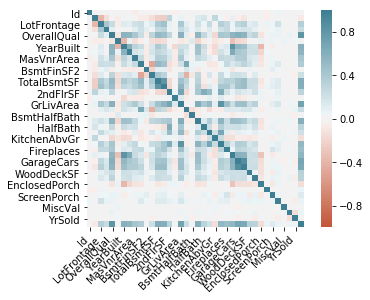

In [12]:
corr = df_raw.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

C:\Users\Alan\Anaconda3\envs\ai\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Alan\Anaconda3\envs\ai\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


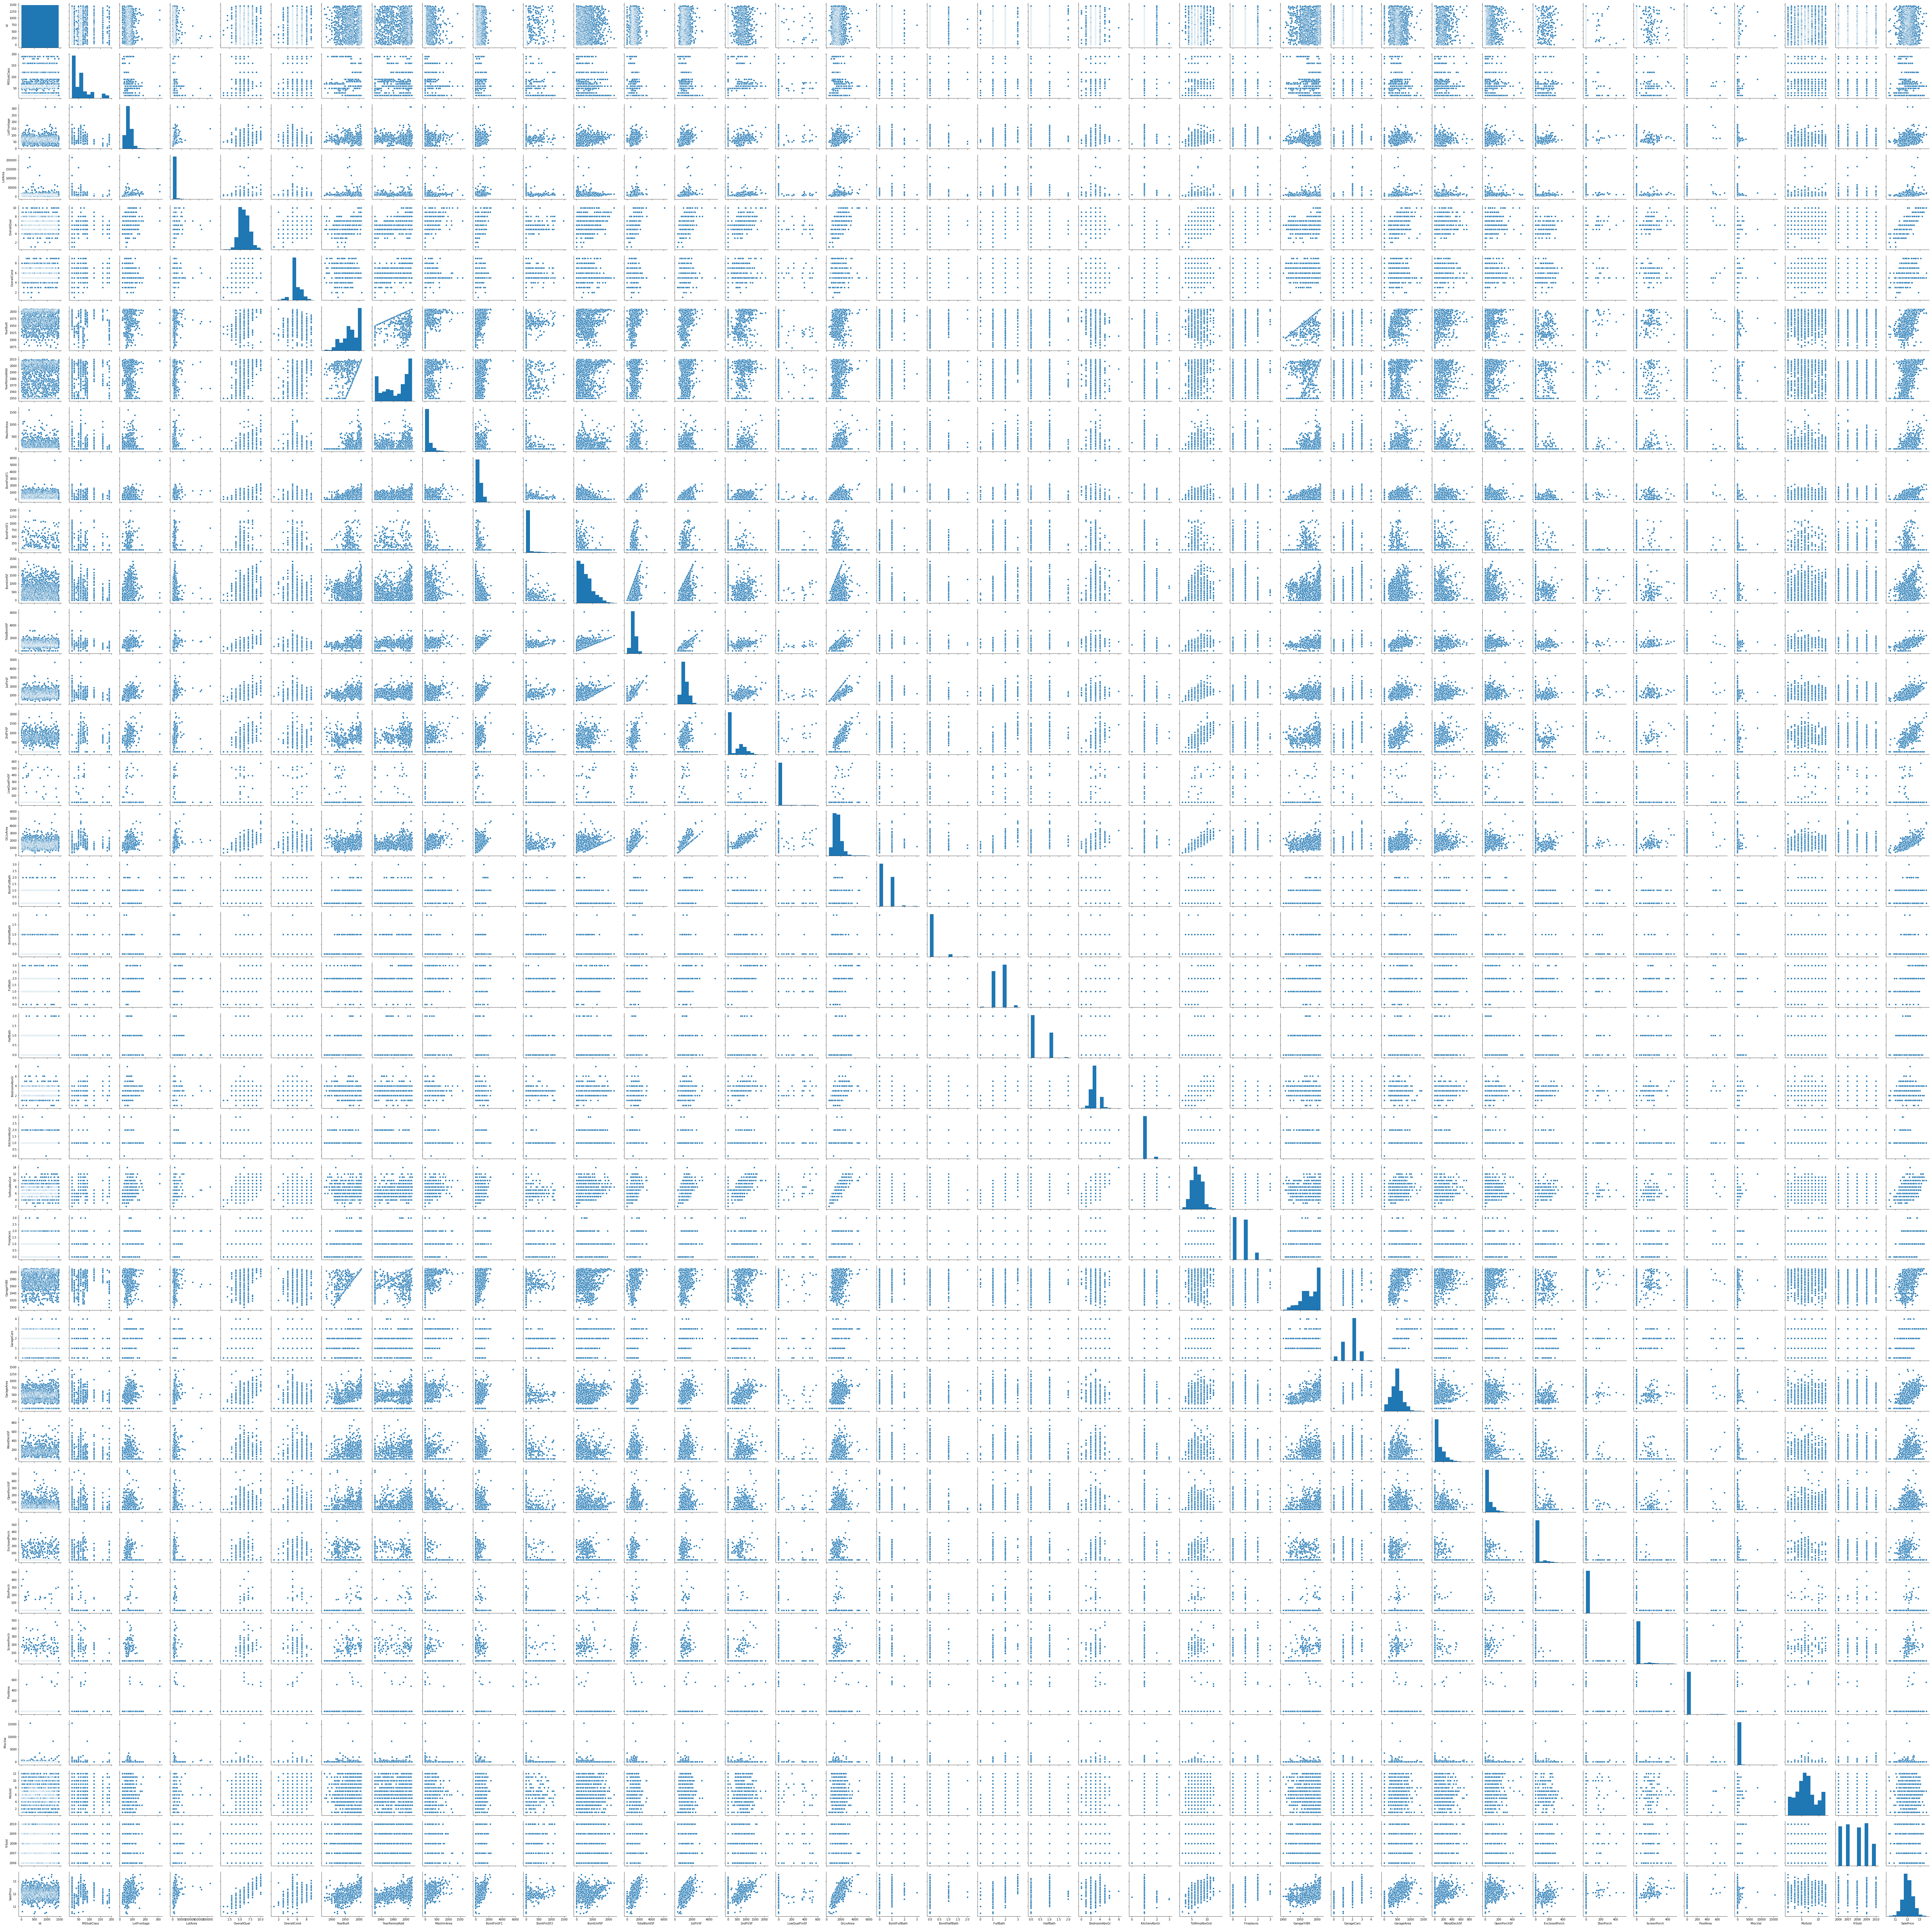

In [12]:
sns.pairplot(df_raw)

C:\Users\Alan\Anaconda3\envs\ai\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Alan\Anaconda3\envs\ai\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


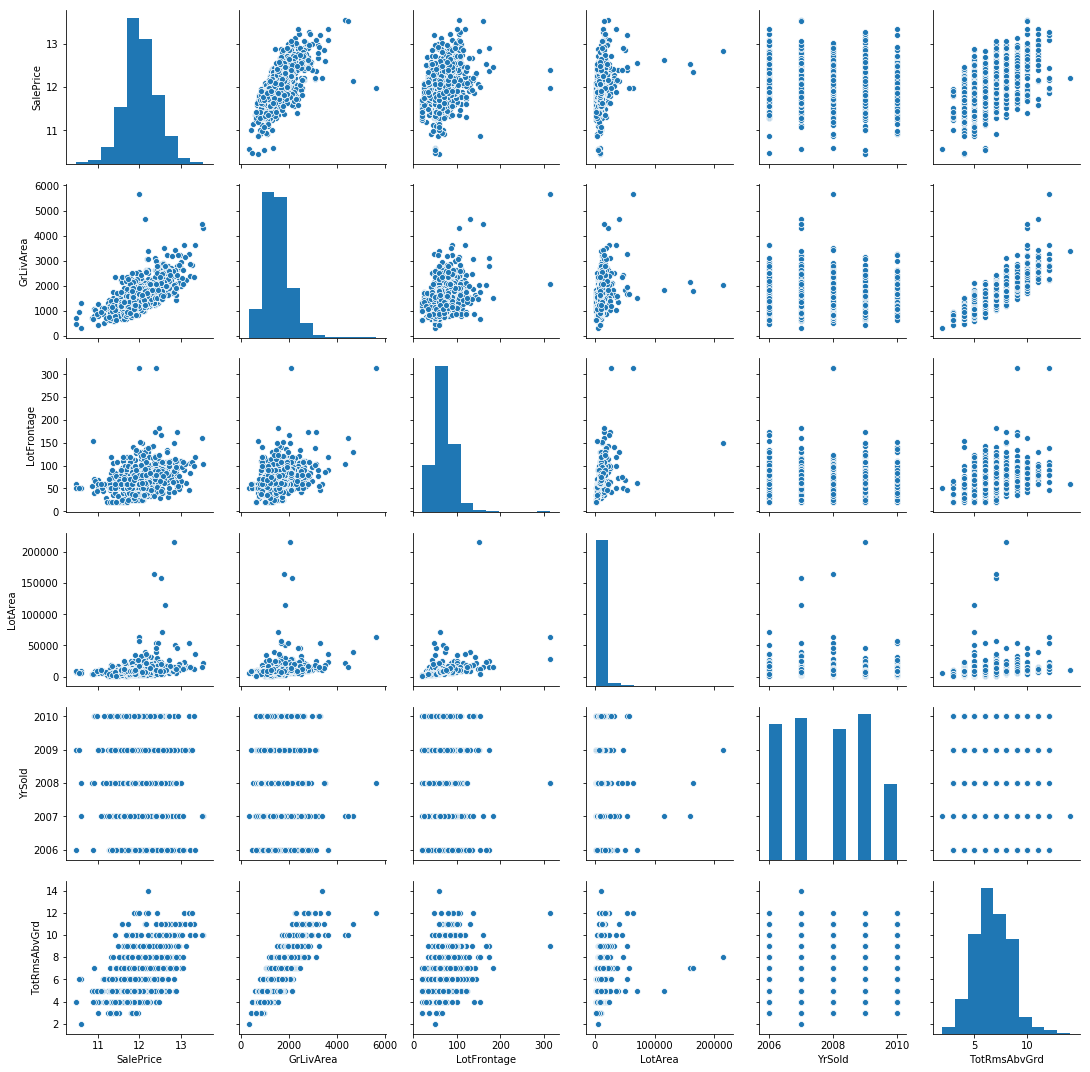

In [13]:
sns.pairplot(data = df_raw, vars=['SalePrice','GrLivArea','LotFrontage','LotArea','YrSold','TotRmsAbvGrd'])

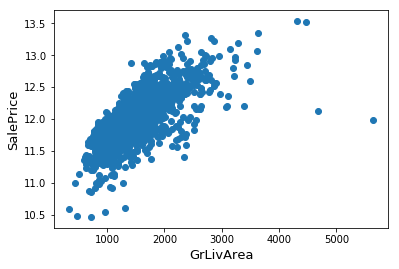

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = df_raw['GrLivArea'], y = df_raw['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

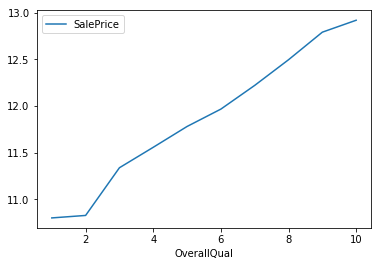

In [15]:
df_raw[['SalePrice','OverallQual']].groupby('OverallQual').mean().plot()

In [16]:
years = df_raw['YearBuilt'].unique().tolist()
len(years)

112

In [17]:
df_raw['elapse']= df_raw['YearRemodAdd']-df_raw['YearBuilt']
df_test['elapse']= df_test['YearRemodAdd']-df_test['YearBuilt']

In [18]:
df_raw.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities   ...   PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub   ...      NaN   NaN         NaN       0      2   
1         Lvl    AllPub   ...      NaN   NaN         NaN       0      5   
2         Lvl    AllPub   ...      NaN   NaN         NaN       0      9   
3         Lvl    AllPub   ...      NaN   NaN         NaN       0      2   
4         Lvl    AllPub   ...      NaN   NaN         NaN       0     12   

  YrSold SaleType  SaleCondition  SalePrice  elapse  
0   2008       WD         Normal  12.247699       0  
1   2007       WD         Normal  12.109016       0  
2   2008       WD         Normal  12.317171       1  
3   2006       WD        Abnorml  11.849405      55  
4   2008       WD         Normal  12.429220       0  

[5 rows x 82 columns]

In [19]:
#remember where to divide train and test
ntrain = df_raw.shape[0]
ntest = df_test.shape[0]

#Save the 'Id' column
train_ID = df_raw['Id']
test_ID = df_test['Id']

In [20]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

df_all = concat_df(df_raw, df_test)

df_raw.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set' 

dfs = [df_raw, df_test]

df_all.shape

(2919, 82)

In [21]:
df_all.drop('Id',axis=1,inplace=True)

In [22]:
for col in ('Alley','MasVnrType','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
            'BsmtFinType2','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond','PoolQC','Fence','MiscFeature','MSZoning'):
    df_all[col] = df_all[col].fillna('None')

In [23]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    df_all[col] = df_all[col].fillna(0)

In [26]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
skewness = df_all.select_dtypes(include=numerics).apply(lambda x: skew(x))
skew_index = skewness[abs(skewness) >= 0.85].index
skewness[skew_index].sort_values(ascending=False)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
elapse            2.063712
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
GarageYrBlt      -3.906205
dtype: float64

In [27]:
lam = 0.15

for column in skew_index:
    df_all[column] = boxcox1p(df_all[column], lam)

In [28]:
df_train=df_all.iloc[:ntrain].copy()

In [29]:
dftest = df_all.iloc[ntrain:].copy()

In [30]:
cont_list, cat_list = cont_cat_split(df=df_train, max_card=10, dep_var='SalePrice')

In [31]:
cont_list

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MSSubClass',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'ScreenPorch',
 'TotalBsmtSF',
 'WoodDeckSF',
 'elapse']

In [32]:
tfm = Categorify(cat_list, cont_list)
tfm(df_train)
tfm(dftest, test=True)

In [33]:
tfmm = FillMissing(cat_list, cont_list)
tfmm(df_train)
tfmm(dftest, test=True)

In [34]:
norm = Normalize(cat_list, cont_list)
norm.apply_train(df_train)
norm.apply_test(dftest)

In [35]:
def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

In [36]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.

 
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [37]:
df, y, nas = proc_df(df_train, 'SalePrice')

In [38]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 364 
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1096, 81), (1096,), (364, 81))

In [37]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [33]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05443547979354022, 0.14397467866421346, 0.9818559498185528, 0.8597465984930929, 0.864632218185491]


In [34]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07674633347960227, 0.14435488793439705, 0.9639350444771443, 0.8590048561912306, 0.8643927074680673]


In [35]:
m = RandomForestRegressor(n_estimators=80,max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0524782016168199, 0.13515238581217734, 0.9831372649827054, 0.8764085008519842, 0.8716314489218046]


In [36]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [37]:
fi = rf_feat_importance(m, df); fi[:10]

cols       imp
62  OverallQual  0.314447
38    GrLivArea  0.146144
76    YearBuilt  0.114264
73  TotalBsmtSF  0.043224
32   GarageCars  0.040638
22    ExterQual  0.035677
31   GarageArea  0.032852
0      1stFlrSF  0.032718
8    BsmtFinSF1  0.018100
27   Fireplaces  0.016589

In [38]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

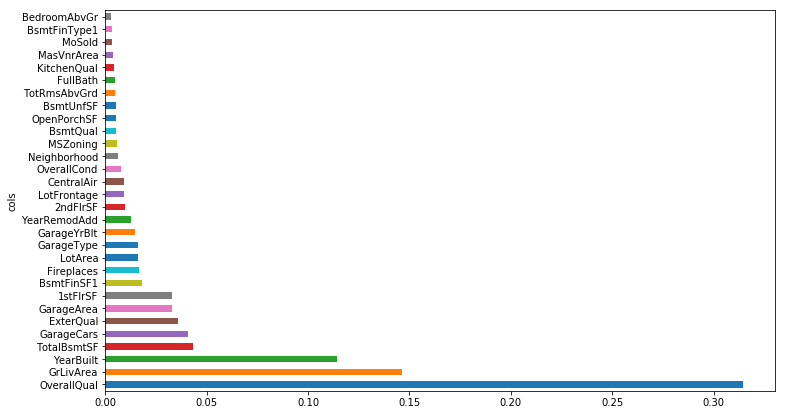

In [39]:
plot_fi(fi[:30]);

In [40]:
to_keep = fi[fi.imp>0.02].cols; len(to_keep)

8

In [41]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [42]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3,max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1071102794233505, 0.15815675429160073, 0.9297522477256488, 0.8307546853799567, 0.8289786612747053]


In [43]:
df_trn2, y_trn, nas = proc_df(df_train, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

In [44]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=3,max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07845749487101976, 0.1373798540014952, 0.9623088835174025, 0.8723010671421518, 0.8700502185234948]


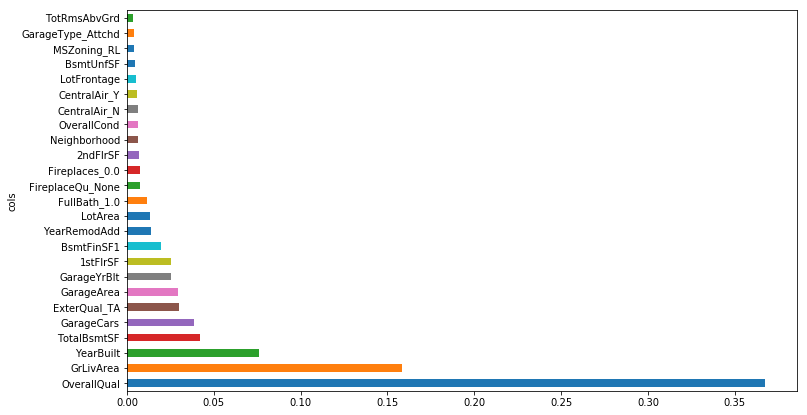

In [45]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

In [46]:
to_keep = fi[fi.imp>0.01].cols; len(to_keep)

13

In [47]:
df_keep = df_trn2[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [48]:
m = RandomForestRegressor(n_estimators=80,max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05648442922675345, 0.14908580761042742, 0.9804643611837447, 0.8496117964429375, 0.8552116892524549]


In [49]:
from scipy.cluster import hierarchy as hc

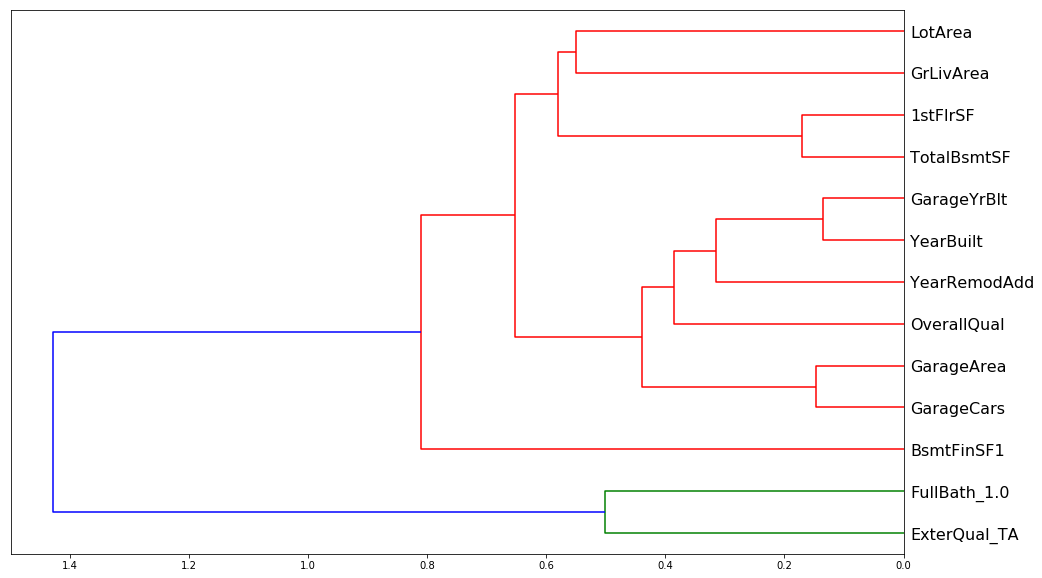

In [50]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [51]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [52]:
get_oob(df_keep)

0.8447958632086807

In [53]:
for c in ('GarageArea','GarageCars','1stFlrSF','TotalBsmtSF'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

GarageArea 0.8498654239727708
GarageCars 0.8461762459437419
1stFlrSF 0.8453439631559331
TotalBsmtSF 0.8509981515818017


In [54]:
to_drop = [ '1stFlrSF']
get_oob(df_keep.drop(to_drop, axis=1))

0.8486419135681285

In [55]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [56]:
m = RandomForestRegressor(n_estimators=80,max_features=.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.057007388512122684, 0.14823866483700518, 0.9801009464267504, 0.8513160273391139, 0.8596525096070278]


In [57]:
from pdpbox import pdp
from plotnine import *

In [58]:
df_trn2, y_trn, nas = proc_df(df_train, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=80,max_features=.5, n_jobs=-1)
m.fit(X_train, y_train);

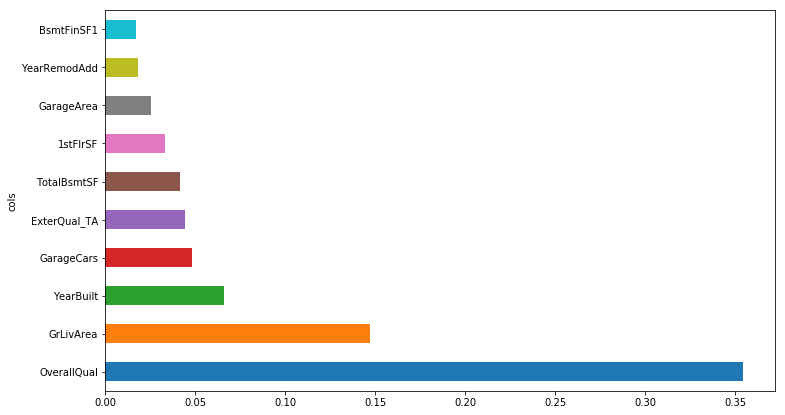

In [59]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

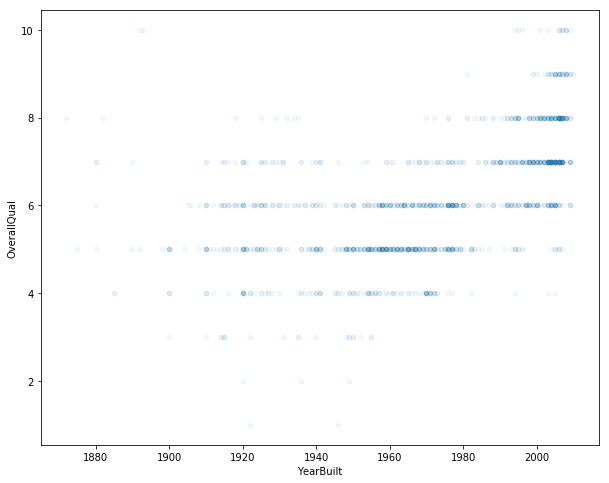

In [60]:
df_raw.plot('YearBuilt', 'OverallQual', 'scatter', alpha=0.05, figsize=(10,8));

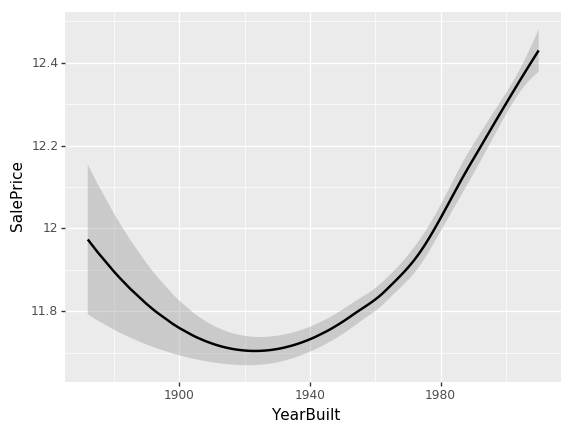

<ggplot: (81397489058)>

In [61]:
ggplot(df_raw, aes('YearBuilt', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [62]:
x = X_train

In [63]:
def plot_pdp(feat_name, clusters=None):
    #feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature=feat_name, model_features=x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12f3a9e0b70>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12f3aa53128>})

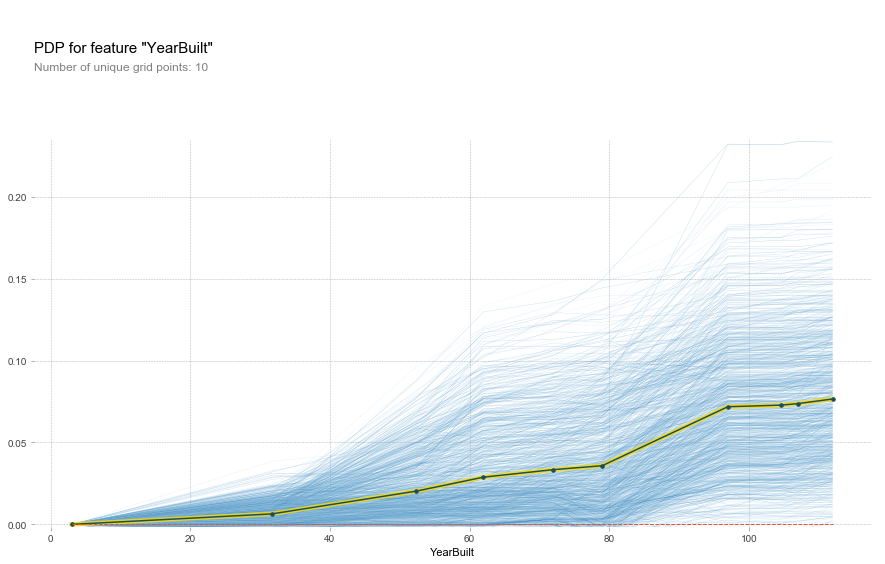

In [64]:
plot_pdp('YearBuilt')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12f3ac21668>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x12f3ac342b0>})

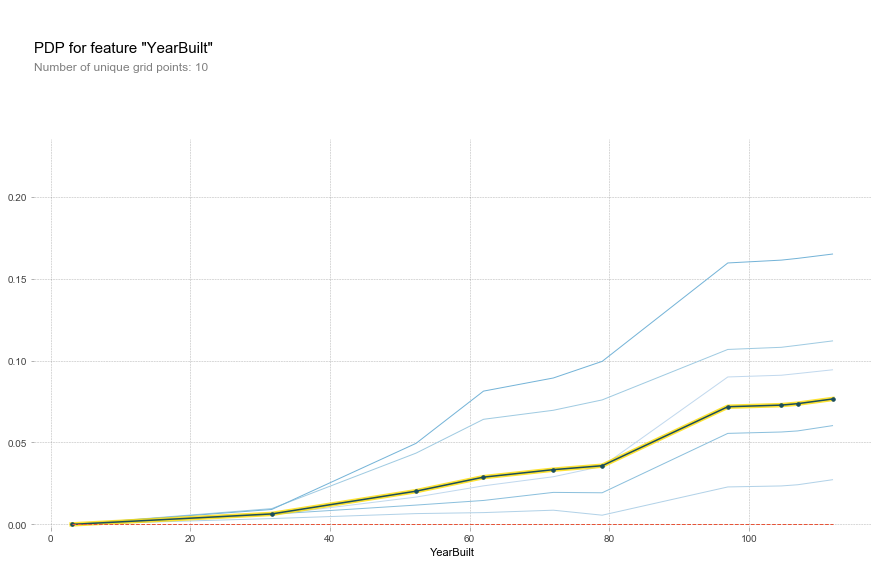

In [65]:
plot_pdp('YearBuilt', clusters=5)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

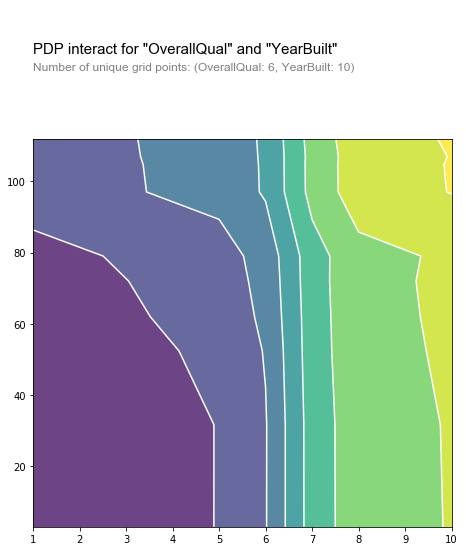

In [112]:
feats = ['OverallQual', 'YearBuilt']
p = pdp.pdp_interact(m, x, features=feats, model_features=x.columns)
pdp.pdp_interact_plot(p, feats)

<h3>Using Neural Networks</h3>

In [39]:
dep_var = 'SalePrice'

In [40]:
train=df_all.iloc[:ntrain].copy()

In [41]:
test=df_all.iloc[ntrain:].copy()

In [42]:
procs = [FillMissing, Normalize, Categorify]

In [43]:
data = (TabularList.from_df(train, path=PATH, cont_names=cont_list,cat_names=cat_list,procs=procs)
                           .split_by_rand_pct(valid_pct=0.2, seed=10)
                           .label_from_df(cols=dep_var, label_cls=FloatList)
                            .add_test(TabularList.from_df(dftest, path=PATH, cont_names=cont_list,cat_names=cat_list))
                           .databunch())

In [44]:
learn = tabular_learner(data, layers=[200,100], emb_drop=0.2,metrics=root_mean_squared_error,callback_fns=ActivationStats)

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


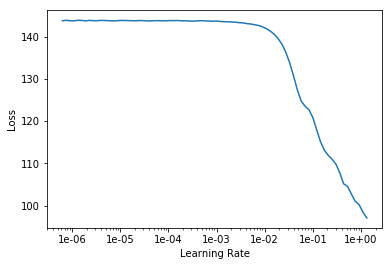

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(20, .09)

In [47]:
learn.activation_stats.stats.shape

torch.Size([2, 61, 360])

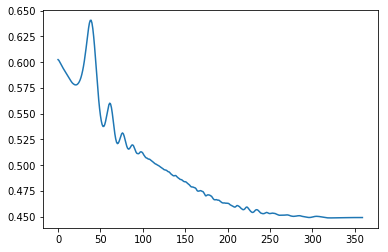

In [48]:
plt.plot(learn.activation_stats.stats[1][-2].numpy());

In [49]:
pred_test,_ = learn.get_preds(DatasetType.Test)

In [50]:
preds = np.exp(pred_test)

In [51]:
preds = preds.numpy()

In [52]:
preds

array([[10955.006 ],
       [13930.736 ],
       [14162.332 ],
       [15522.2705],
       ...,
       [ 8843.269 ],
       [15842.8125],
       [ 9647.3125],
       [16199.269 ]], dtype=float32)

In [53]:
submi = pd.DataFrame(preds,columns=['SalePrice'], index=df_test.Id)

In [54]:
submi

SalePrice
Id                
1461  10955.005859
1462  13930.736328
1463  14162.332031
1464  15522.270508
1465  16086.223633
1466  13272.799805
1467  18126.582031
1468  13051.879883
1469  13971.942383
1470  12034.302734
1471  16637.789062
1472   9078.702148
1473   9060.313477
1474  12494.734375
1475  10055.515625
1476  17445.568359
1477  14761.689453
1478  20155.240234
1479  18697.130859
1480  27808.820312
1481  20348.433594
1482  14561.243164
1483  15386.691406
1484  14918.741211
1485  15179.263672
1486  15524.683594
1487  20764.775391
1488  18393.027344
1489  15414.464844
1490  20859.927734
...            ...
2890   7752.742676
2891  12033.808594
2892   4384.111328
2893   5329.749023
2894   4915.504883
2895  20870.353516
2896  17261.324219
2897  14759.817383
2898  13852.083984
2899  15669.710938
2900  13185.332031
2901  15269.354492
2902  15612.043945
2903  23441.863281
2904  23948.091797
2905   8580.178711
2906  13805.055664
2907  10430.674805
2908  12166.374023
2909  14378.059570
2910   8346.083984
2911   7056.307617
2912  14741.122070
2913   8529.009766
2914   8442.854492
2915   8880.344727
2916   8843.268555
2917  15842.812500
2918   9647.312500
2919  16199.268555

[1459 rows x 1 columns]

In [55]:
submi.to_csv(f'{PATH}NN.csv', index_label='Id')